## Electron density visualisation

In [1]:
# import packages
import pyscf
import numpy as np

In [2]:
# create molecule and run RHF calculation
mol = pyscf.gto.Mole()
mol.build(
    atom = """H -2 0 0; H 2 0 0""", # default distance unit is angstrom
    basis = "6-31++g",
    unit = 'bohr',  # specify Bohr units: default is A but underlying calculations of AO stuff is in Bohr.
    symmetry="C1"
)
mf = pyscf.scf.RHF(mol) # init HF object
mf.kernel() # run SCF

converged SCF energy = -0.907689765843393


-0.9076897658433929

In [3]:
# # benzene
# mol = pyscf.gto.Mole()
# mol.build(
#     atom = """
#     C   0.000000   1.396792   0.000000
#     H   0.000000   2.481081   0.000000
#     C  -1.209657   0.698396   0.000000
#     H  -2.147732   1.240540   0.000000
#     C  -1.209657  -0.698396   0.000000
#     H  -2.147732  -1.240540   0.000000
#     C   0.000000  -1.396792   0.000000
#     H   0.000000  -2.481081   0.000000
#     C   1.209657  -0.698396   0.000000
#     H   2.147732  -1.240540   0.000000
#     C   1.209657   0.698396   0.000000
#     H   2.147732   1.240540   0.000000
#     """,  # Coordinates are in angstroms by default
#     basis = "sto-3g",
#     unit = 'angstrom',  # specifying angstrom units for coordinates
#     symmetry = "C1"  # No symmetry, can be set to 'D6h' for benzene but set to C1 for RHF
# )

# # Initialize the RHF object
# mf = pyscf.scf.RHF(mol)

# # Run the SCF calculation
# mf.kernel()


The first-order electron density operator $\hat{\rho}(\mathbf{r})$ is defined in first quantisation as
$$
\hat{\rho}(\mathbf{r}) = \sum_{i}^N \delta(\mathbf{r_i} - \mathbf{r}).
$$

We define the Hartree-Fock Slater determinant $\ket{\Phi} = |\phi_1 \phi_2 ... \phi_N|$ as 
$$
 \prod_i a_i^\dag \ket{0},
 $$
such that we can define the density operator in second quantisation (cf. Helgaker CH1) as
$$\hat{\rho}(\mathbf{r}) = \sum_{pq}^K \rho(\mathbf{r})_{pq} a_p^\dag a_q$$
with
$$
\rho(\mathbf{r})_{pq} = \int d\mathbf{r}' \phi_p^*(\mathbf{r}') \delta(\mathbf{r}' - \mathbf{r}) \phi_q(\mathbf{r}') =
 \phi_p^*(\mathbf{r})\phi_q(\mathbf{r})
 $$

This gives us the first-order electron density
$$
 \bra{\Phi}\hat{\rho}(\mathbf{r})\ket{\Phi} = \sum_{pq}^K \phi_p^*(\mathbf{r})\phi_q(\mathbf{r}) \bra{\Phi}a_p^\dag a_q\ket{\Phi} = 
\sum_{pq}^K \phi_p^*(\mathbf{r})\phi_q(\mathbf{r}) \gamma_{pq} = \sum_i^{N_{occ}} \phi_i^*(\mathbf{r})\phi_i(\mathbf{r}).
$$
Expanding the MOs in a basis of atomic orbitals $\chi$
$$
\ket{\phi_p} = \sum_\mu C_{\mu i} \ket{\chi_\mu}
$$
and defining the first order density matrix (1-RDM)
$$
D_{\mu\nu} = \sum_i^{N_{occ}} C_{\mu i} C_{\nu i}^*
$$
we find
$$
\bra{\Phi}\hat{\rho}(\mathbf{r})\ket{\Phi} = \sum_{\mu \nu} D_{\nu\mu} \chi_\mu^*(\mathbf{r}) \chi_\nu(\mathbf{r}).
$$

We thus need to obtain the values of each AO for each point in space.

In [4]:
def get_basis_set_data(mol):
    # number of AOs in basis
    nao = mol.nao
    nel = mol.nelectron
    ao_coords = mol.atom_coords()

    # get contraction coeffs and exponents of each AO basis function
    grouped_ctr_coeffs = []
    grouped_exps = []
    angulars = []

    # set up different counters to access data for degenerate (p, d, ...) AOs
    counter_compr = 0 # counter for counting the number of ao's, seeing degenerate orbitals (cf p) as one
    counter_tot = 0 # counter for counting the total number of unique ao's

    while counter_tot < nao:
        grouped_ctr_coeffs.append(mol.bas_ctr_coeff(counter_compr))
        grouped_exps.append(mol.bas_exp(counter_compr))
        angular_mom = mol.bas_angular(counter_compr)
        angulars.append(angular_mom)
        degen = 2*angular_mom + 1
        counter_compr += 1
        counter_tot += degen

    return nao, nel, grouped_ctr_coeffs, grouped_exps, angulars, ao_coords

def unpack_degen_aos(nao, nel, grouped_ctr_coeffs, grouped_exps, angulars, ao_coords):
    """Unpack AO metadata for each degenerate AO also. (E.g. one gruoped ctr coeffs, exps) for each p_i orbital, and specified angular direction for each"""
    # ctr coeffs and exponents
    unpacked_ctr_coeffs = []
    unpacked_exps = []
    unpacked_angular_functions = []
    for i, am in enumerate(angulars):
        degen = 2*am + 1
        for _ in range(degen):
            unpacked_ctr_coeffs.append(grouped_ctr_coeffs[i])
            unpacked_exps.append(grouped_exps[i])
        # for am: save angular function
        if am == 0:
            unpacked_angular_functions.append(lambda r: 1) # return 1
        if am == 1:
            unpacked_angular_functions.append(lambda r: r[0]) # return x
            unpacked_angular_functions.append(lambda r: r[1]) # return y
            unpacked_angular_functions.append(lambda r: r[2]) # return z
        if am == 2:
            unpacked_angular_functions.append(lambda r: r[0] * r[1]) # return xy
            unpacked_angular_functions.append(lambda r: r[1] * r[2]) # return yz
            unpacked_angular_functions.append(lambda r: r[2] * r[0]) # return zx
            unpacked_angular_functions.append(lambda r: r[0]**2 - r[1]**2) # return x**2 - y**2
            unpacked_angular_functions.append(lambda r: 2*r[2]**2 - r[0]**2 - r[1]**2) # return 2z**2 - x**2 - y**2

    # ao coords
    unpacked_ao_coords = []
    for atom_coord in ao_coords:
        # add coords as many times as there are ao's for each atom
        for i in range(nao//nel):
            unpacked_ao_coords.append(atom_coord)

    assert nao == len(unpacked_ctr_coeffs) == len(unpacked_exps) == len(unpacked_angular_functions) == len(unpacked_ao_coords), 'lengths of each unpacked list should be identical'

    return unpacked_ctr_coeffs, unpacked_exps, unpacked_angular_functions, unpacked_ao_coords


def get_AO_val_at_r(r_vec, ao_id, unpacked_ctr_coeffs, unpacked_exps, unpacked_angular_functions, unpacked_ao_coords):
    """Get the value of a gaussian AO at a specific cartesian coord.
    input:
    r_vec: (list) cartesian coordinates of the requested point, eg [1.2, 0, 0]
    ao_id: (int) index of the ao you're accessing
    others: see output of unpack_degen_aos
    """
    # check that AM is supported
    for angular in angulars:
        assert angular < 2, 'this function currently only supports s, p, and d orbitals.'

    # set up cartesian coordinates
    x, y, z = r_vec # requested point
    atom_x, atom_y, atom_z = unpacked_ao_coords[ao_id] # centre of this AO

    # build GTO expression
    def GTO(x, y, z):
        value = 0
        # add weighted value of each uncontracted GTO to final output
        for i, ctr_coeff in enumerate(unpacked_ctr_coeffs[ao_id]):
            # c * AM(r_vec) * radial_part(r_vec)
            value += ctr_coeff * unpacked_angular_functions[ao_id](r_vec) * np.exp(- unpacked_exps[ao_id][i] * ((x - atom_x)**2 + (y - atom_y)**2 + (z - atom_z)**2)) # unpacked_exps contain unique exp for each uncontracted gaussian
        return value
    
    return GTO(x, y, z)[0] # GTO output is 0D array, need content as float

# example:
nao, nel, grouped_ctr_coeffs, grouped_exps, angulars, ao_coords = get_basis_set_data(mol)
unpacked_ctr_coeffs, unpacked_exps, unpacked_angular_functions, unpacked_ao_coords = unpack_degen_aos(nao, nel, grouped_ctr_coeffs, grouped_exps, angulars, ao_coords)
get_AO_val_at_r([0, 1, 0], 0, unpacked_ctr_coeffs, unpacked_exps, unpacked_angular_functions, unpacked_ao_coords)

0.033150535576136904

In [5]:
def get_el_density_at_r(r_vec, mol, hf_obj):
    # get density matrix
    density_matrix = mf.make_rdm1()
    # get value of each AO at location r
    AO_values = []
    for ao_id in range(mol.nao):
        nao, nel, grouped_ctr_coeffs, grouped_exps, angulars, ao_coords = get_basis_set_data(mol)
        unpacked_ctr_coeffs, unpacked_exps, unpacked_angular_functions, unpacked_ao_coords = unpack_degen_aos(nao, nel, grouped_ctr_coeffs, grouped_exps, angulars, ao_coords)
        AO_values.append(get_AO_val_at_r(r_vec, ao_id, unpacked_ctr_coeffs, unpacked_exps, unpacked_angular_functions, unpacked_ao_coords))
    # gather into one matrix
    AO_values = np.array(AO_values)
    AO_values_matrix = np.einsum('i, j -> ij', AO_values.conj(), AO_values)

    # perform contraction
    return np.einsum('ij, ij ->', density_matrix, AO_values_matrix)

In [6]:
# Define the grid resolution and range
x_min, x_max = -3.0, 3.0  # Bohr
y_min, y_max = -3.0, 3.0  # Bohr
grid_points = 100  # Number of points along each axis

# Create the x and y coordinates for the grid
x_coords = np.linspace(x_min, x_max, grid_points)
y_coords = np.linspace(y_min, y_max, grid_points)

# Initialize the 2D array to store electron densities
electron_density = np.zeros((grid_points, grid_points))

# Compute electron density at each point in the xy-plane
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        # Create the r_vec for the xy-plane, z = 0
        r_vec = np.array([x, y, 0.0])
        # Compute electron density at this point
        electron_density[i, j] = get_el_density_at_r(r_vec, mol, mf)

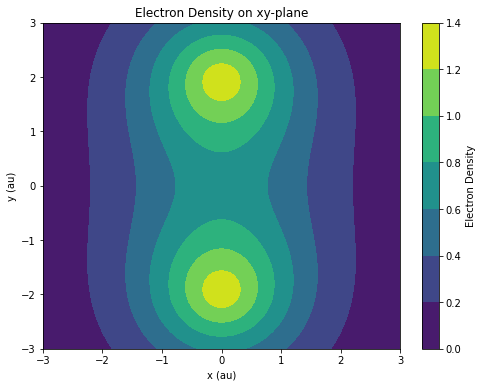

In [7]:
import matplotlib.pyplot as plt

# Create a meshgrid for plotting
X, Y = np.meshgrid(x_coords, y_coords)

# Plot the electron density using contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, electron_density, cmap='viridis')
plt.colorbar(cp, label='Electron Density')
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.title('Electron Density on xy-plane')
plt.show()
